In [259]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
import warnings
warnings.filterwarnings("ignore")

import jax
from jax import vmap
import jax.random as jrandom
import jax.numpy as jnp
import jax.scipy.stats as jstats
import pandas as pd
import numpy as np
import gpjax as gpx
from flax import nnx
import optax
from typing import Optional
from jaxtyping import Float, Array

jax.config.update("jax_enable_x64", True)
key = jrandom.PRNGKey(0);

# Example of Gaussian Process Surrogate

## Model for subcutaneous autoinjectors

In this notebook, we'll replicate [Sree et. al. (2023)](https://doi.org/10.1016/j.jmbbm.2023.105695) by creating a Gaussian process (GP) surrogate of an expensive biomechanical model.

### Background

Autoinjectors are drug delivery devices that work kind of like an automated syringe. 
Basically, you put the device against the patient's skin, press a button, and a spring within the device pushes the needle, releasing drug inside the patient.
<!-- Autoinjectors are nice because they simplify the injection process for the user so that patients can self-administer at home.  -->

<img src="autoinjector.png" alt="autoinjector" width="400"/>

*Picture of an autoinjector [from here](https://taltz.lilly.com/taking-taltz).*

To efficently design an optimal autoinjector, you need a computational model of the injection process.
To this end, [Sree et. al. (2023)](https://doi.org/10.1016/j.jmbbm.2023.105695) present a biomechanical model of injection into subcutaneous tissue (i.e., the tissue right below your skin) via an autoinjector.

<img src="coupled-injection-model.png" alt="coupled-injection-model" height="300"/> <img src="injection-simulation.png" alt="injection-simulation" height="300"/>

**Left:** *Schematic of the autoinjector model.* **Right:** *Finite element simulation of tissue stress during injection.* *From Sree et. al. (2023).* 

The model, however, is expensive to evaluate&mdash;multiple hours on several parallel processors for one evaluation.
This is too slow for things like design optimization or uncertainty quantification.
So we will speed it up by training a surrogate.
Let's get started.

### Dataset

To train the surrogate, we'll use a dataset with thousands of evaluations of the expensive model (data was provided by the authors [Sree et. al.](https://doi.org/10.1016/j.jmbbm.2023.105695)).
Let's import the data:

In [2]:
# Define new names for each input/output variable
old_input_names = ['mu', 'fill_volume', 'hGap0', 'lNeedle', 'dNeedle', 'FSpring0', 'kSpring', 'kappa5', 'kappa6', 'kappa7']
INPUT_NAMES = ['viscosity_cP', 'fill_volume_mL', 'air_gap_height_mm', 'needle_length_mm', 'needle_diameter_mm', 'spring_force_N', 'spring_constant_N_per_mm', 'kappa5', 'kappa6', 'kappa7']
old_output_names = ['Needle displacement (m)', 'Injection time (s)', 'max. acceleration (m/s^2)', 'max. deceleration (m/s^2)']
OUTPUT_NAMES = ['needle_displacement_m', 'injection_time_s', 'max_acceleration_m_per_s2', 'max_deceleration_m_per_s2']
column_name_mapper = dict(zip(old_input_names + old_output_names, INPUT_NAMES + OUTPUT_NAMES))

# Load the data
train_data = pd.read_excel("training_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)
test_data = pd.read_excel("test_data.xlsx", index_col=0).rename(columns=column_name_mapper).sample(frac=1).reset_index(drop=True)

# Split data. Pass in column names to ensure correct order.
X_train = pd.DataFrame(train_data[INPUT_NAMES], columns=INPUT_NAMES)  
y_train = pd.DataFrame(train_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)
X_test = pd.DataFrame(test_data[INPUT_NAMES], columns=INPUT_NAMES)
y_test = pd.DataFrame(test_data[OUTPUT_NAMES], columns=OUTPUT_NAMES)

The model has 10 inputs and 4 outputs. The inputs are things like drug viscosity, needle size, tissue biomechanical properties, etc. The outputs are the maximum acceleration/deceleration of fluid in syringe, the total time of injection, and the depth of needle insertion at the onset of drug delivery.

### Preprocessing

Ideally, we want the input and output data to be standarized and more-or-less evenly distributed. This helps avoid any numerical difficulties when training GPs. 

Let's visualize the distribution of each input:

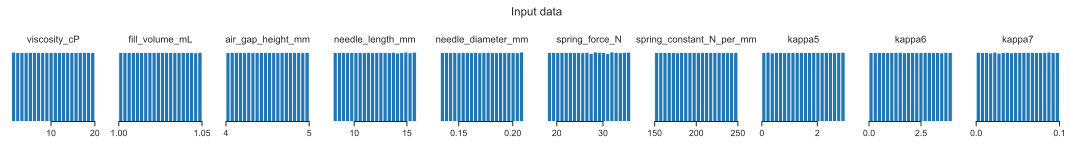

In [3]:
fig, ax = plt.subplots(1, X_train.shape[1], figsize=(15, 2), tight_layout=True, sharey=True)
fig.suptitle("Input data")
for i, col in enumerate(INPUT_NAMES):
    ax[i].hist(X_train[col], bins=20)
    ax[i].set_title(col)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

They are evenly distributed, but not standarized (i.e., the means and standard deviations are not 0 and 1, respectively). Let's standardize the input data:

In [4]:
class StandardScaler:
    """A transform that standarizes the data to have mean=0 and stdev=1.
    
    Parameters
    ----------
    data : Float[Array, "N d"]
        The data to be standarized. Shape is (N, d)=(number of samples, dimensionality).
    pretransform_forward : Optional[callable]
        An optional transformation to apply to the data before standarizing.
    pretransform_inverse : Optional[callable]
        The inverse of pretransform_forward.
    """
    def __init__(
        self, 
        data: Float[Array, "N d"], 
        pretransform_forward: Optional[callable] = None, 
        pretransform_inverse: Optional[callable] = None
    ):
        # Set up pre-transform functions
        if (pretransform_forward is None) ^ (pretransform_inverse is None):
            raise ValueError("Both pretransform_forward and pretransform_inverse must be provided.")
        elif pretransform_forward is None:
            pretransform_forward = lambda x: x
            pretransform_inverse = lambda x: x
        self.pre_forward = pretransform_forward
        self.pre_inverse = pretransform_inverse
        
        # Compute parameters for the standarizer
        pretransformed_data = self.pre_forward(data)
        self.mean = jnp.mean(pretransformed_data, axis=0)
        self.std = jnp.std(pretransformed_data, axis=0)        
    
    def forward(self, x):
        return (self.pre_forward(x) - self.mean) / self.std
    
    def inverse(self, y):
        return self.pre_inverse(y * self.std + self.mean)

In [5]:
input_transform = StandardScaler(X_train.values)
X_train_scaled = jnp.array(input_transform.forward(X_train.values))
X_test_scaled = jnp.array(input_transform.forward(X_test.values))

Now let's visualize the distribution of each output:

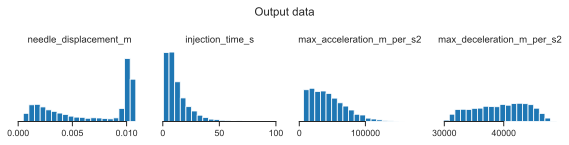

In [6]:
fig, ax = plt.subplots(1, y_train.shape[1], figsize=(8, 2), tight_layout=True, sharey=True)
fig.suptitle("Output data")
for i, col in enumerate(OUTPUT_NAMES):
    ax[i].hist(y_train[col], bins=20)
    ax[i].set_title(col)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

Some of the outputs are skewed. Let's apply a log transformation, then standarize the output data:

In [7]:
@vmap
def partial_log_transform(x):
    return jnp.hstack([x[0], jnp.log(x[1]), jnp.log(x[2]), x[3]])

@vmap
def partial_exp_transform(y):
    return jnp.array([y[0], jnp.exp(y[1]), jnp.exp(y[2]), y[3]])

output_transform = StandardScaler(y_train.values, pretransform_forward=partial_log_transform, pretransform_inverse=partial_exp_transform)
y_train_scaled = jnp.array(output_transform.forward(y_train.values))
y_test_scaled = jnp.array(output_transform.forward(y_test.values))

Okay, now let's visualize the transformed inputs and outputs:

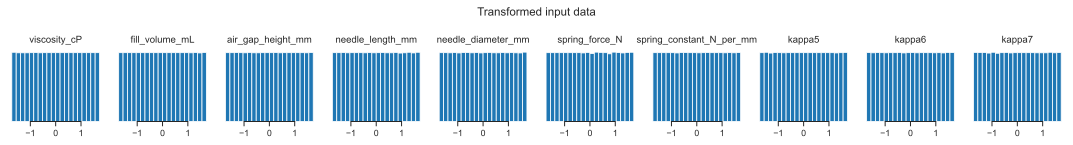

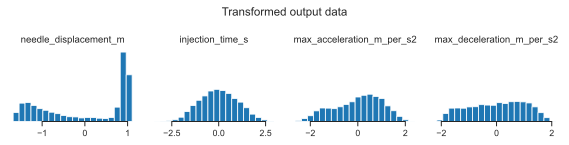

In [8]:
fig, ax = plt.subplots(1, X_train_scaled.shape[1], figsize=(15, 2), tight_layout=True, sharey=True)
fig.suptitle("Transformed input data")
for i, i_name in enumerate(INPUT_NAMES):
    ax[i].hist(X_train_scaled[:, i], bins=20)
    ax[i].set_title(i_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

fig, ax = plt.subplots(1, y_train_scaled.shape[1], figsize=(8, 2), tight_layout=True, sharey=True)
fig.suptitle("Transformed output data")
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].hist(y_train_scaled[:, i], bins=20)
    ax[i].set_title(o_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

Nice! The input/output data are all more-or-less evenly distributed and standarized. Now on to building the Gaussian process.

## Gaussian process regression

We will use `GPJax` to construct 4 different GP surrogates, one for each output. We'll write the math down for one of the outputs, but the same applies to the other outputs.

### Prior

First, let's create the GP prior with zero mean, i.e., 

$$
m(x) = 0
$$

and a radial basis function (RBF) as the covariance kernel, i.e.,

$$
k(x, x') = \sigma^2 \exp\left(-\frac{1}{2} \sum_{i=1}^d \left(\frac{x_i - x'_i}{\ell_i}\right)^2\right)
$$

where $\sigma^2$ is the variance and $\ell_i$ is the length scale for input dimension $i$. We write the prior as

$$
f \sim \mathcal{GP}(m, k).
$$

Here is how to do it in `GPJax`:

In [9]:
# Zero mean
mean = gpx.mean_functions.Zero()

# Set the lengthscale/variance to decent values - they will be optimized later.
kernel = gpx.kernels.RBF(lengthscale=jnp.ones(X_train_scaled.shape[1]), variance=1.0)

# GP prior
prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)

### Likelihood

We'll use a Gaussian likelihood. For input data 

$$
\mathbf{X} \equiv \begin{bmatrix} \mathbf{x}_1 \\ \vdots \\ \mathbf{x}_N \end{bmatrix} \in \mathbb{R}^{N \times d}
$$ 

and output data 

$$
\mathbf{y} \equiv \begin{bmatrix} y_1 \\ \vdots \\ y_N \end{bmatrix} \in \mathbb{R}^N
$$

we have that

$$
y_i|f, \mathbf{x}_i \sim \mathcal{N}(f(\mathbf{x_i}), \sigma_n^2) \quad \text{independently for } i = 1, \ldots, N,
$$

where $f$ is the physical model (or a sample from the GP) and $\sigma_n^2$ is the measurement noise variance. Coding this in `GPJax` is straightworward:

In [10]:
likelihood = gpx.likelihoods.Gaussian(
    num_datapoints=y_train.shape[0],
    # obs_stddev=gpx.parameters.Parameter(0.001, tag='static')  # Fixing measurement noise to something small.
    obs_stddev=0.01
)

### Posterior

We can now construct the GP posterior

$$
f | \mathbf{X}, \mathbf{y} \sim \mathcal{GP}(m_{\text{post}}, k_{\text{post}})
$$

In [11]:
posterior = prior * likelihood

### Optimizing hyperparameters

For each GP posterior, the hyperparameters are the RBF kernel variance $\sigma^2$, lengthscales $\mathbf{\ell}=(\ell_1, \dots, \ell_d)$, and measurement noise variance $\sigma_n^2$. 

Let's denote the hyperparameters as $\psi=(\sigma^2, \mathbf{\ell}, \sigma_n^2)$.
We'll pick optimal $\psi$ by maximizing the marginal log likelihood, i.e.,

$$
\psi^* = \arg\max_{\psi} ~ \log p(\mathbf{y} | \mathbf{X}, \psi).
$$

`GPJax` provides the functions `conjugate_mll` and `fit` to do this. (Note that we do everything in a loop so each output gets its own GP surrogate.)

In [12]:
# Loss function: negative marginal log likelihood
negative_mll = nnx.jit(lambda p, d: -gpx.objectives.conjugate_mll(p, d))

def optimize_gps(posterior, datasets, num_iters=1000, batch_size=128, learning_rate=1e-2, verbose=True, *, key):
    """Optimizes the hyperparameters in the GP model (separately for each output)."""
    posteriors = {}
    loss_histories = {}
    
    # Do this in a loop to construct a GP for each output.
    for i, o_name in enumerate(OUTPUT_NAMES):
        key, subkey = jrandom.split(key)
        posteriors[o_name], loss_histories[o_name] = gpx.fit(
            model=posterior,
            objective=negative_mll,
            train_data=datasets[o_name],
            optim=optax.adam(learning_rate),  # Adam optimizer
            num_iters=num_iters,
            batch_size=batch_size,
            key=subkey,
            verbose=verbose
        )

    return posteriors, loss_histories

def create_datasets(size=None, X=X_train_scaled, y=y_train_scaled, output_names=OUTPUT_NAMES):
    """Creates a GPJax datasets (one for each output) out of a subset of the training data."""
    if size is None:
        size = X.shape[0]
    datasets = {}
    for i, o_name in enumerate(output_names):
        datasets[o_name] = gpx.Dataset(X[:size], y[:size, i:i+1])
    return datasets

In [13]:
# Create a separate dataset for each output (and put it all in a single dictionary)
datasets = create_datasets(size=200)

# Optimize the hyperparameters
key, subkey = jrandom.split(key)
posteriors, loss_histories = optimize_gps(posterior, datasets, key=subkey)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We now have an optimized GP for each output!

In [14]:
posteriors['needle_displacement_m'].prior.kernel.lengthscale

PositiveReal(
  _tag='positive',
  value=Array([0.89398692, 5.37938492, 5.19130139, 1.52742274, 2.12174445,
         2.61498712, 5.09279493, 5.46752322, 2.11813042, 5.12751518],      dtype=float64)
)

## Predictive distribution: How to evaluate the GP?

The question now is **how do we use our GPs to make predictions?** The predictive distribution for a new input $\mathbf{x}^*$ is given by

$$
p\big( f(\mathbf{x}^*) \big | \mathcal{D})
= \int \underbrace{p\big( f(\mathbf{x}^*) \big | f(\mathbf{x}) \big)}_{\substack{\text{conditional probability} \\ \text{of output at } \mathbf{x}^*}} \underbrace{p\big(f(\mathbf{x}) \big| \mathcal{D}\big)}_{\substack{\text{posterior GP} \\ \text{evaluated at } \mathbf{x}}} df(\mathbf{x})
$$

GPJax provides the function `predict` which can be used to give the mean and variance of the predictive distribution $p\big( f(\mathbf{x}^*) \big| \mathcal{D} \big)$. Or, we can sample from the predictive distribution using the function `sample`.

To facilitate making new predictions, let's wrap `predict` and `sample` with the following helper class, which represents the surrogate:

In [113]:
class Surrogate(object):
    def __init__(
        self, 
        models, 
        train_data,
        input_transform, 
        input_inv_transform,
        output_transform, 
        output_inv_transform,
        OUT_NAMES=OUTPUT_NAMES, 
        IN_NAMES=INPUT_NAMES
    ):
        self.models = models
        self.train_data = train_data
        self.input_transform = input_transform
        self.input_inv_transform = input_inv_transform
        self.output_transform = output_transform
        self.output_inv_transform = output_inv_transform
        self.OUT_NAMES = OUT_NAMES
        self.IN_NAMES = IN_NAMES
        
    def __call__(self, X):
        """
        Evaluate the model at X.
        """
        Z = self.input_transform(X)
        y = self.get_scaled_predictive_mean_stdev(Z)[0]  # Just the mean
        return self.output_inv_transform(y)

    def sample(self, X, num_samples, *, key):
        """Sample the output. Contains both aleatoric and epistemic uncertainty."""
        Z = self.input_transform(X)
        y = self.sample_scaled_predictive(Z, num_samples, key=key)
        return self.output_inv_transform(y)
    
    def sample_scaled_predictive(self, X, num_samples, *, key):
        """Sample the scaled output. Contains both aleatoric and epistemic uncertainty."""
        predictive_dists = self._get_predictive_dists(X)
        y = []
        for o_name in self.OUT_NAMES:
            samples = predictive_dists[o_name].sample(seed=key, sample_shape=(num_samples,))
            y.append(samples)
        y = jnp.concatenate(y, axis=1)
        return y
    
    def sample_latent(self, X, num_samples, *, key):
        """Sample the latent space of the model (i.e., a GP sample before passing through the likelihood). Contains only epistemic uncertainty."""
        latent_dists = self._get_latent_dists(X)
        f = []
        for o_name in self.OUT_NAMES:
            samples = latent_dists[o_name].sample(seed=key, sample_shape=(num_samples,))
            f.append(samples)
        f = jnp.concatenate(f, axis=1)
        return f
    
    def get_scaled_predictive_mean_stdev(self, X):
        """Get the mean and standard deviation of the scaled output. Contains both aleatoric and epistemic uncertainty."""
        predictive_dists = self._get_predictive_dists(X)
        y_mean = []
        y_stdev = []
        for o_name in self.OUT_NAMES:
            y_mean.append(predictive_dists[o_name].mean())
            y_stdev.append(predictive_dists[o_name].stddev())
        return jnp.stack(y_mean, axis=1), jnp.stack(y_stdev, axis=1)
    
    def get_latent_mean_stdev(self, X):
        """Get the mean and standard deviation of the latent distribution. Contains only epistemic uncertainty."""
        latent_dists = self._get_latent_dists(X)
        f_mean = []
        f_stdev = []
        for o_name in self.OUT_NAMES:
            f_mean.append(latent_dists[o_name].mean())
            f_stdev.append(latent_dists[o_name].stddev())
        return jnp.stack(f_mean, axis=1), jnp.stack(f_stdev, axis=1)
    
    def _get_latent_dists(self, X):
        latent_dists = {}
        for o_name in self.OUT_NAMES:
            latent_dists[o_name] = self.models[o_name].predict(X, self.train_data[o_name])
        return latent_dists
    
    def _get_predictive_dists(self, X):
        latent_dists = self._get_latent_dists(X)
        predictive_dists = {}
        for o_name in self.OUT_NAMES:
            predictive_dists[o_name] = self.models[o_name].likelihood(latent_dists[o_name])
        return predictive_dists

In [114]:
surrogate_ = Surrogate(
    models=posteriors,
    train_data=datasets,
    input_transform=input_transform.forward,
    input_inv_transform=input_transform.inverse,
    output_transform=output_transform.forward,
    output_inv_transform=output_transform.inverse
)

Now let's make a prediction at a new input location. 

In [123]:
# Select a random test point
x = X_test.values[0:1]
x_scaled = input_transform.forward(x)

# Evaluate the mean and standard deviation
y_scaled_mean, y_scaled_stdev = surrogate_.get_scaled_predictive_mean_stdev(x_scaled)

print('The scaled predictions are:')
for i, o_name in enumerate(OUTPUT_NAMES):
    print(f"\t{o_name:<25}:  {y_scaled_mean[0, i]:.2f} +/- {y_scaled_stdev[0, i]:.2f}")

The scaled predictions are:
	needle_displacement_m    :  -0.03 +/- 0.31
	injection_time_s         :  0.06 +/- 0.06
	max_acceleration_m_per_s2:  0.26 +/- 0.12
	max_deceleration_m_per_s2:  0.03 +/- 0.05


This is one advantage of GP surrogates&mdash;they provide uncertainty estimates!

Let's visualize the (unscaled) output probability distributions. We can do this by sampling from the GP posterior:

In [126]:
y_latent_samples = surrogate_.sample(x, num_samples=1000, key=key)

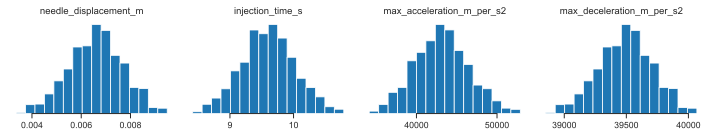

In [127]:
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 2), tight_layout=True)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].hist(y_latent_samples[:,i], bins=16, density=True)
    ax[i].set_title(o_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

The uncertainty you see here is the *epistemic uncertainty* (or "lack-of-data" uncertainty). It should go down as we add more data points. We'll look at this next.

## Convergence: How much data do we need?

Ideally, we want to use enough data so that the epistemic uncertainty is low.
Let's test how much data we need for this problem.
We'll create training datasets of sizes $N=50, 500, 1000, 1500, 2000$ and observe the convergence of the trained GP.

In [122]:
dataset_sizes = [50, 500, 1000, 1500, 2000]
datasets_N = {size: create_datasets(size) for size in dataset_sizes}

surrogates_N = {}
posteriors_N = {}
loss_histories_N = {}

for N in dataset_sizes:
    print(f'Now training GP for dataset with size {N:<3} ... ', end='')

    key, subkey = jrandom.split(key)
    posteriors_N[N], loss_histories_N[N] = optimize_gps(posterior, datasets_N[N], verbose=False, key=subkey)

    surrogates_N[N] = Surrogate(
        models=posteriors_N[N],
        train_data=datasets_N[N],
        input_transform=input_transform.forward,
        input_inv_transform=input_transform.inverse,
        output_transform=output_transform.forward,
        output_inv_transform=output_transform.inverse
    )

    print('done.')

Now training GP for dataset with size 50  ... done.
Now training GP for dataset with size 500 ... done.
Now training GP for dataset with size 1000 ... done.
Now training GP for dataset with size 1500 ... done.
Now training GP for dataset with size 2000 ... done.


We now have trained GPs for each dataset size, stored in `surrogates_N`. 
Note how the epistemic uncertainty decreases as we add more data:

In [129]:
y_latent_samples_N = {}
for i, N in enumerate(dataset_sizes):
    y_latent_samples_N[N] = surrogates_N[N].sample_latent(x_scaled, num_samples=1000, key=key)

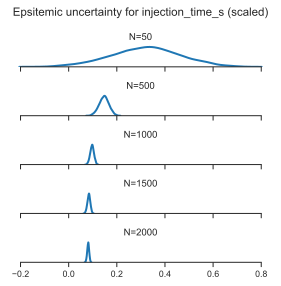

In [130]:
output_index = 1  # Select an output

fig, ax = plt.subplots(len(dataset_sizes), 1, figsize=(4, 4), tight_layout=True, sharex=True, sharey=False)
for i, N in enumerate(dataset_sizes):
    fig.suptitle(f'Epsitemic uncertainty for {OUTPUT_NAMES[output_index]} (scaled)')
    sns.kdeplot(y_latent_samples_N[N][:,output_index], ax=ax[i], lw=2)
    ax[i].set_title(f'N={N}')
    ax[i].set_yticks([])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    sns.despine(trim=True, ax=ax[i], left=True)

Let's visualize the convergence for each (scaled) output. Below, we plot the epistemic uncertainty as a vertical bar:

In [131]:
means_N = {}
stdevs_N = {}
for i, N in enumerate(dataset_sizes):
    means_N[N], stdevs_N[N] = surrogates_N[N].get_latent_mean_stdev(x_scaled)

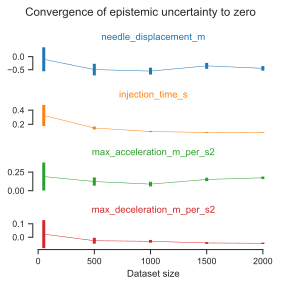

In [132]:
fig, ax = plt.subplots(len(OUTPUT_NAMES), 1, figsize=(4, 4), tight_layout=True, sharey=False)
fig.suptitle('Convergence of epistemic uncertainty to zero')
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].errorbar(dataset_sizes, [means_N[N][0, i] for N in dataset_sizes], yerr=[stdevs_N[N][0, i] for N in dataset_sizes], ls='-', lw=0.5, elinewidth=3, label=f'{o_name} (scaled)', color=f'C{i}')
    ax[i].set_title(o_name, color=f'C{i}')
    # ax[i].set_yticks([])
    if i == len(OUTPUT_NAMES) - 1:
        sns.despine(trim=True, ax=ax[i])
    else:
        sns.despine(trim=True, ax=ax[i], bottom=True)
        ax[i].set_xticks([])
ax[-1].set_xlabel('Dataset size');

For $N>1000$ the epistemic uncertainty is low for all outputs. We'll use the GP trained with 1000 points for subsequent analysis.

In [133]:
surrogate = surrogates_N[1000]

## Diagnostics: How good is the surrogate?

The next question is: **How accurate is our surrogate?** We will use our test dataset to find out.

### Parity plot

Let's plot the predicted output against the true output (for the test dataset):

In [136]:
means_train, stdevs_train = surrogate.get_scaled_predictive_mean_stdev(X_train_scaled[:1000])
means_test, stdevs_test = surrogate.get_scaled_predictive_mean_stdev(X_test_scaled)

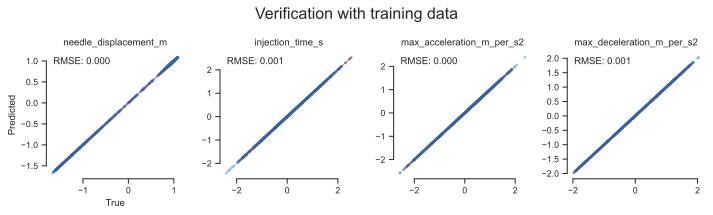

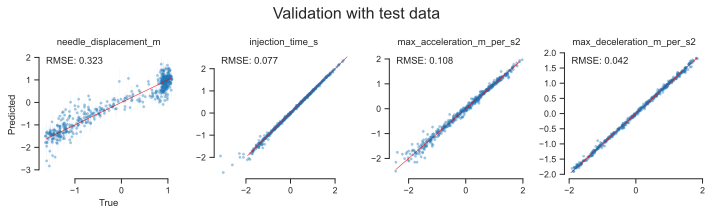

In [145]:
rmse = lambda y, y_hat: jnp.sqrt(jnp.mean((y - y_hat)**2))

fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('Verification with training data', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].errorbar(y_train_scaled[:1000, i], means_train[:, i], yerr=2 * stdevs_train[:, i], fmt='o', ms=2, alpha=0.3, lw=0.1)
    ax[i].plot(datasets[o_name].y, datasets[o_name].y, "r-", lw=0.5, zorder=100)
    ax[i].annotate(f"RMSE: {rmse(y_train_scaled[:1000, i], means_train[:, i]):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
    ax[i].set_title(o_name)
    sns.despine(trim=True, ax=ax[i])
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted')

fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('Validation with test data', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].errorbar(y_test_scaled[:, i], means_test[:, i], yerr=2 * stdevs_test[:, i], fmt='o', ms=2, alpha=0.3, lw=0.1)
    ax[i].plot(datasets[o_name].y, datasets[o_name].y, "r-", lw=0.5, zorder=100)
    ax[i].annotate(f"RMSE: {rmse(y_test_scaled[:, i], means_test[:, i]):.3f}", xy=(0.05, 0.9), xycoords='axes fraction')
    ax[i].set_title(o_name)
    sns.despine(trim=True, ax=ax[i])
ax[0].set_xlabel('True')
ax[0].set_ylabel('Predicted');

As expected, we fit the training data perfectly (all points lie on the red line). However, we mostly care about how well we predict unseen (test) data. The root mean square error (RSME) along with the parity plots show that some outputs are predicted better than others.

For GPs, parity plots and RSME values are good for checking if our predictive *mean* function is correct. However, they do not say anything about whether our *uncertainty* estimates are correct. For that, we must look at the standardized errors.

### Standardized errors

For the $i^\text{th}$ test data point, the *standardized error* $e_i$ is

$$
e_i = \frac{y_i - m(x_i)}{\sigma(x_i)}
$$

where $y_i$ is the true output, and $m(x_i)$ and $\sigma(x_i)$ are the mean and standard deviation of the prediction, respectively.

In [195]:
standardized_errors = (y_test_scaled - means_test) / stdevs_test

Let's use these standardized errors to validate the GP's uncertainty estimates.

#### Error histogram

The basic GP model (which is what we have) assumes normally distributed errors. Let's check this:

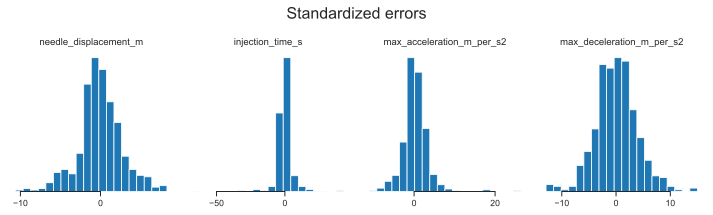

In [196]:
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('Standardized errors', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].hist(standardized_errors[:, i], bins=20)
    ax[i].set_title(o_name)
    ax[i].set_yticks([])
    sns.despine(trim=True, ax=ax[i], left=True)

#### QQ plot

The histograms above look like normal distributions, but it's sometimes hard to tell.
A quantile-quantile (QQ) plot is another way to check normality:

In [202]:
quantiles = jnp.linspace(0.01, 0.99, 40)
normal_quantiles = jstats.norm.ppf(quantiles)
error_quantiles = jnp.quantile(standardized_errors, quantiles, axis=0)

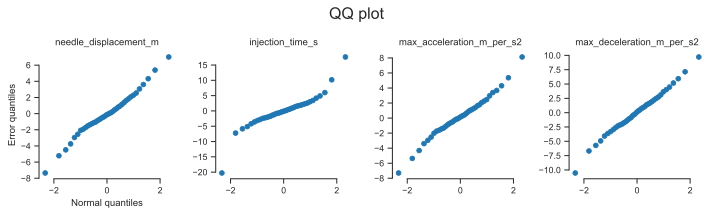

In [203]:
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('QQ plot', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].scatter(normal_quantiles, error_quantiles[:, i])
    ax[i].set_title(o_name)
    sns.despine(trim=True, ax=ax[i])
ax[0].set_xlabel('Normal quantiles')
ax[0].set_ylabel('Error quantiles');

The straighter the line, the more "normal" the errors are. They look decent.

#### Residuals plot

Another assumption in our GP model is that the noise is *homoscedastic*&mdash;i.e., the same across all input/output values. We can check this assumption by plotting the error against the model prediction. This is called a *residual plot*. (Note that *residuals* is just another name for the errors.)

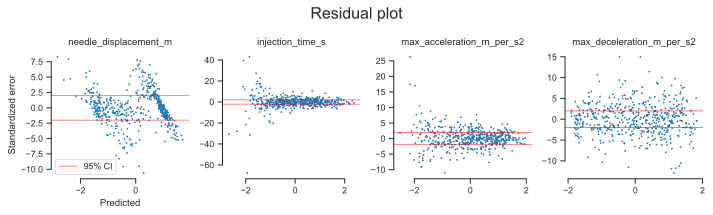

In [257]:
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(10, 3), tight_layout=True)
fig.suptitle('Residual plot', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].scatter(means_test[:, i], standardized_errors[:, i], 1)
    ax[i].set_title(o_name)
    ax[i].axhline(-2, color='r', lw=0.5, label=r'95% CI')
    ax[i].axhline(2, color='r', lw=0.5)
    sns.despine(trim=True, ax=ax[i])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Standardized error')
ax[0].legend();

The variance in the errors seems to change with the output value. Similar to the parity plots, this basically tells us that the GP fit is somewhat off and we may need more training data. (Whether we actually use more data depends, of course, on how accurate we need our surrogate to be.)

## Sensitivity analysis with surrogate

Now that we have a trained and tested surrogate, there are many useful things we can do with it. As an example, we'll demonstrate using the surrogate to do Sobol sensitivity analysis.

First, let's get the ranges over which we expect the inputs to vary:

In [232]:
import SALib.sample.sobol as sobol
import SALib.analyze.sobol as analyze_sobol

input_bounds_dict = {
    'viscosity_cP': [1.0, 20.0],
    'fill_volume_mL': [1.0, 1.05],
    'air_gap_height_mm': [4.0, 5.0],
    'needle_length_mm': [8.0, 15.9],
    'needle_diameter_mm': [0.133, 0.21],
    'spring_force_N': [18.0, 36.0],
    'spring_constant_N_per_mm': [150.0, 250.0],
    'kappa5': [0.0, 3.0],
    'kappa6': [0.0, 4.0],
    'kappa7': [0.0, 0.1]
}
input_bounds = np.array([[input_bounds_dict[i][0], input_bounds_dict[i][1]] for i in INPUT_NAMES])
print('The input bounds are:\n', input_bounds)

The input bounds are:
 [[1.00e+00 2.00e+01]
 [1.00e+00 1.05e+00]
 [4.00e+00 5.00e+00]
 [8.00e+00 1.59e+01]
 [1.33e-01 2.10e-01]
 [1.80e+01 3.60e+01]
 [1.50e+02 2.50e+02]
 [0.00e+00 3.00e+00]
 [0.00e+00 4.00e+00]
 [0.00e+00 1.00e-01]]


Next, we create Sobol samples of the inputs and pass them through the surrogate:

In [237]:
problem = {
    'num_vars': len(INPUT_NAMES),
    'names': INPUT_NAMES,
    'bounds': input_bounds
}

# The number of samples to generate (should be a power of 2).
N = 512

# Generate the samples.
sobol_samples = sobol.sample(problem, N, calc_second_order=False)

# Evaluate the surrogate model at the Sobol samples.
sobol_outputs = surrogate(sobol_samples)

Finally, we calculate and plot the Sobol indices:

In [244]:
sobol_indices = {}
for i, o_name in enumerate(OUTPUT_NAMES):
    sobol_indices[o_name] = analyze_sobol.analyze(problem, sobol_outputs[:, i], calc_second_order=False, print_to_console=False)

/Users/holtw/Documents/mydocs/software/advanced-scientific-machine-learning/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


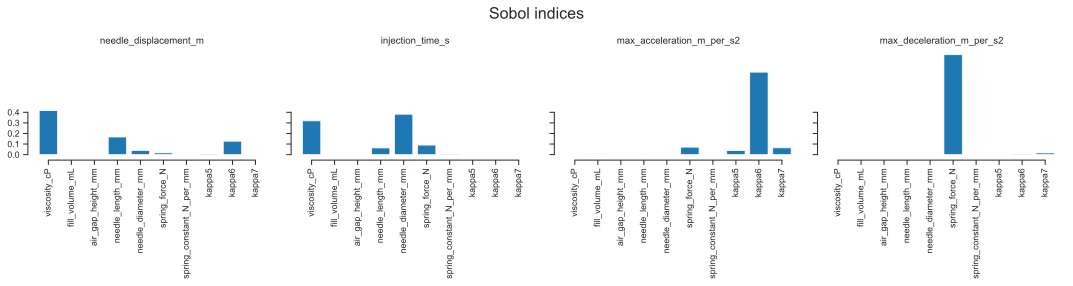

In [256]:
# Plot sobol indices
fig, ax = plt.subplots(1, len(OUTPUT_NAMES), figsize=(15, 4), tight_layout=True, sharey=True)
fig.suptitle('Sobol indices', fontsize=16)
for i, o_name in enumerate(OUTPUT_NAMES):
    ax[i].bar(problem['names'], sobol_indices[o_name]['S1'])
    ax[i].set_title(o_name)
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    sns.despine(trim=True, ax=ax[i])

Excellent! We now know to which inputs the outputs are most sensitive. For example, we can see that the injection time is *very* sensitive to the drug viscosity and needle diameter, *somewhat* sensitive to needle length and injector spring force, and *not* sensitive to any other inputs. This information can be used, for example, to further study and understand the physics behind the model, or to investigate how identifiable each parameter is given an experimental dataset.

Remember that **sensitivity analysis would have *not* been feasible without a surrogate model**&mdash;the true physical model was just too expensive. With a surrogate however, we can do sensitivity analysis, design optimization, uncertainty quantification, etc. all at a reasonable computational cost.